## Import Libs

In [1]:
%load_ext autoreload
%autoreload 2


import os,sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import torch.nn as nn
import hydra


from hydra.core.config_store import ConfigStore
from deepspeech_pytorch.configs.inference_config import EvalConfig
from deepspeech_pytorch.loader.data_loader import SpectrogramDataset, AudioDataLoader
from deepspeech_pytorch.utils import load_model, load_decoder
from deepspeech_pytorch.validation import run_evaluation
from deepspeech_pytorch.model import DeepSpeech, SequenceWise

from utils import *

from ctc_loss_imp import ctc_loss_imp
import matplotlib
%matplotlib inline

In [2]:
# ------------------------------------------------------------------------------
# Config 
# ------------------------------------------------------------------------------
cs = ConfigStore.instance()
cs.store(name="config", node=EvalConfig)

cfg = EvalConfig()

# set bs = 1, device
cfg.batch_size=1
device = torch.device("cuda" if cfg.model.cuda else "cpu")


# ------------------------------------------------------------------------------
# Model
# ------------------------------------------------------------------------------
model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/librispeech_pretrained_v3.ckpt'
model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/outputs/2023-11-01/23-31-50/lightning_logs/version_0/checkpoints/epoch=5-step=19295.ckpt'
model_ds = DeepSpeech.load_from_checkpoint(model_path)
model_ds.train()
model_ds = model_ds.to(device)

# ------------------------------------------------------------------------------
# Data
# ------------------------------------------------------------------------------

test_dir = '/scratch/f006pq6/datasets/librispeech/test_clean'
test_dataset = SpectrogramDataset(
    audio_conf=model_ds.spect_cfg,
    input_path=hydra.utils.to_absolute_path(test_dir),
    labels=model_ds.labels,
    normalize=True
)
test_loader = AudioDataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers
)
# ------------------------------------------------------------------------------
# Get an Input
# ------------------------------------------------------------------------------
data_loader_iter = iter(test_loader)

# inputs, targets, input_percentages, target_sizes = next() 
# inputs = inputs.to(device)
# targets = targets.to(device)


# # ==============================================================================
# # Make the input a bit smaller

# inputs = inputs[:,:,:,-60:-40] # do 100 frames only
# input_percentages[0] = 1.0
# input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
# input_percentages = input_percentages.to(device)

# print('input shape:',inputs.shape)


In [3]:
# inputs, targets, input_percentages, target_sizes = next(data_loader_iter) 
# inputs = inputs.to(device)
# targets = targets.to(device)

# plot_spectrogram(inputs.detach())

# load inputs, targets, input_percentages, target_sizes from pickle data_loader_values.pkl
import pickle
with open( 'data_loader_values.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
inputs, targets, input_percentages, target_sizes = data

input shape: torch.Size([1, 1, 161, 110])


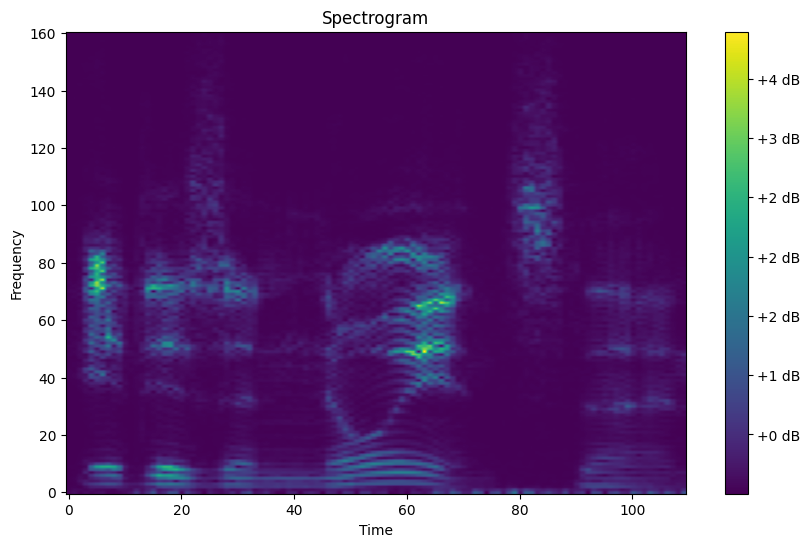

In [5]:
# # ==============================================================================
# Make the input a bit smaller

inputs = inputs[:,:,:,50:160] # do 100 frames only
input_percentages[0] = 1.0
input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
input_percentages = input_percentages.to(device)

print('input shape:',inputs.shape)
plot_spectrogram(inputs.detach())


In [ ]:
target_sizes

In [ ]:
targets
    

In [6]:
for idx in targets:
    print(model_ds.labels[idx], end='')

IT IS ANNOYANCE THEN

In [ ]:
# save inputs, targets, input_percentages, target_sizes to file
# import pickle
# with open('data_loader_values.pkl', 'wb') as f:
#     pickle.dump((inputs, targets, input_percentages, target_sizes), f)


In [7]:
# ------------------------------------------------------------------------------
#  Loss function, get target dL/dW
# ------------------------------------------------------------------------------
##get the param to match gradient
weight_param = model_ds.fc[0].module[1].weight
# weight_param = model_simple.fc2.weight
print('weight shape:', weight_param.shape)

out, output_sizes, hs = model_ds(inputs, input_sizes) # 1 176 29

# make target same size of output size
targets = targets[-out.shape[1]:]
target_sizes[0]= len(targets)


print('model input shape, input_sizes:', inputs.shape, input_sizes)
print('model output shape, output_sizes, hidden sizes:', out.shape, output_sizes, len(hs))
print('target sizes, targets: ', target_sizes, targets)

out = out.transpose(0, 1)  # TxNxH
out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log
# from torch.nn import CTCLoss
# loss_ = CTCLoss(blank=model_ds.labels.index('_'), reduction='sum', zero_infinity=True)(out, targets, output_sizes, target_sizes)
loss_func = lambda x,y :ctc_loss_imp(x, y, output_sizes, target_sizes,reduction='mean')


loss_func_lib   = torch.nn.CTCLoss()
loss = loss_func(out, targets)
loss_lib = loss_func_lib(out, targets, output_sizes, target_sizes)
print('loss:', loss.item())
print('loss by pt lib:', loss_lib.item())
# grab gradient to match
dldw_target= torch.autograd.grad(loss, weight_param)[0]

print('grad shape:',dldw_target.shape, 'grad_norm', dldw_target.norm())


weight shape: torch.Size([29, 1024])
model input shape, input_sizes: torch.Size([1, 1, 161, 110]) tensor([110], dtype=torch.int32)
model output shape, output_sizes, hidden sizes: torch.Size([1, 55, 29]) tensor([55], dtype=torch.int32) 5
target sizes, targets:  tensor([20], dtype=torch.int32) tensor([10, 21, 28, 10, 20, 28,  2, 15, 15, 16, 26,  2, 15,  4,  6, 28, 21,  9,
         6, 15], device='cuda:0')
loss: 1.3467327552756516
loss by pt lib: 1.3467328548431396
grad shape: torch.Size([29, 1024]) grad_norm tensor(6.4759, device='cuda:0')


In [8]:
# ------------------------------------------------------------------------------
# Meta loss
# ------------------------------------------------------------------------------
def meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param):
    loss = loss_func(output, targets)
    dldw = torch.autograd.grad(loss, weight_param, create_graph=True)[0]
    loss = ((dldw-dldw_target)**2).sum() #MSE
    #loss = 1 - torch.nn.functional.cosine_similarity(dldw.reshape(1,-1), dldw_target.reshape(1,-1))

    return loss,dldw


# out, output_sizes, hs = model_ds(x_param, input_sizes) # 1 176 29
# #out = model_ds(x_hat,input_sizes)
# out = out.transpose(0, 1)  # TxNxH
# out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

# loss,dldw = meta_loss(out, targets, None, None, dldw_target,  weight_param)
# print('loss, dldw norm:', loss.item(), torch.norm(dldw))

In [ ]:
inputs.shape

In [9]:

# ------------------------------------------------------------------------------
# Init random input
# ------------------------------------------------------------------------------
FREQ_CUT_OFF=100

x_init = torch.ones_like (inputs[:,:,:FREQ_CUT_OFF,:]).to(device)*0.01
# x_init = x_init- x_init.mean()
# x_init = x_init/ x_init.std()
print('init mean, std:', x_init.mean(), x_init.std())

x_pad  = torch.ones( (inputs.shape[0],inputs.shape[1], inputs.shape[2]-FREQ_CUT_OFF, inputs.shape[3])
                    ).mul(1e-03).to(device)

x_param = torch.nn.Parameter(x_init.to(device),requires_grad=True)
# x_param_full = torch.concat([x_param, x_pad], dim=2)

# plot_tensor_distribution(x_param_full)

init mean, std: tensor(0.0100, device='cuda:0') tensor(0., device='cuda:0')


In [10]:
# ------------------------------------------------------------------------------
# Train
# ------------------------------------------------------------------------------
import torch.optim as optim

optimizer = optim.Adam([x_param], lr=.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=.5,patience=1000)
# scheduler = torch.optim.lr_scheduler.MultiStepLR( optimizer, milestones= [2000, 2500, 3000, 3500], gamma=0.5)

i=0
loss_history = []


In [ ]:
# x_param = x_param.clamp(min=0)

In [ ]:
# x_param.detach().requires_grad

Iteration, Loss, Gradient Norm, Learning Rate:    0, 174.7817, 673.5133, 0.1000


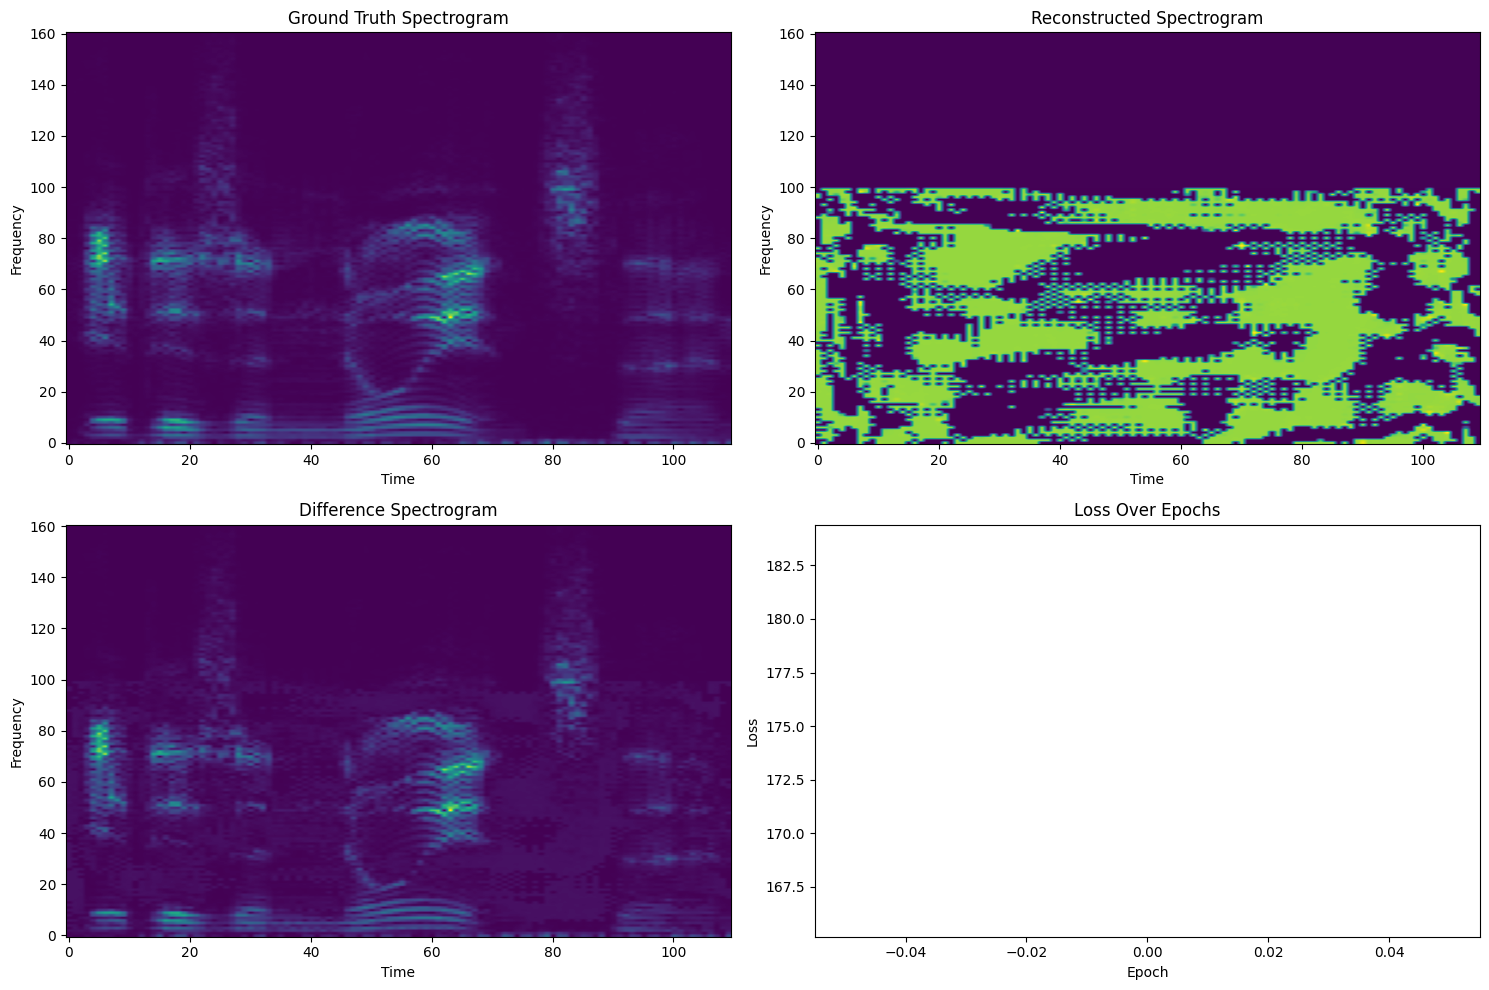

Iteration, Loss, Gradient Norm, Learning Rate:   10, 78.6413, 69.9942, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   20, 73.0472, 52.5462, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   30, 69.2487, 52.3228, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   40, 66.2896, 33.9757, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   50, 64.3709, 33.0773, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   60, 62.5771, 81.3548, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   70, 59.3636, 13.0653, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   80, 72.4231, 88.5886, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   90, 64.0410, 65.7052, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  100, 60.8519, 72.3407, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  110, 58.1590, 13.9303, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  120, 56.9270, 16.8301, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  130, 55.9088, 9.

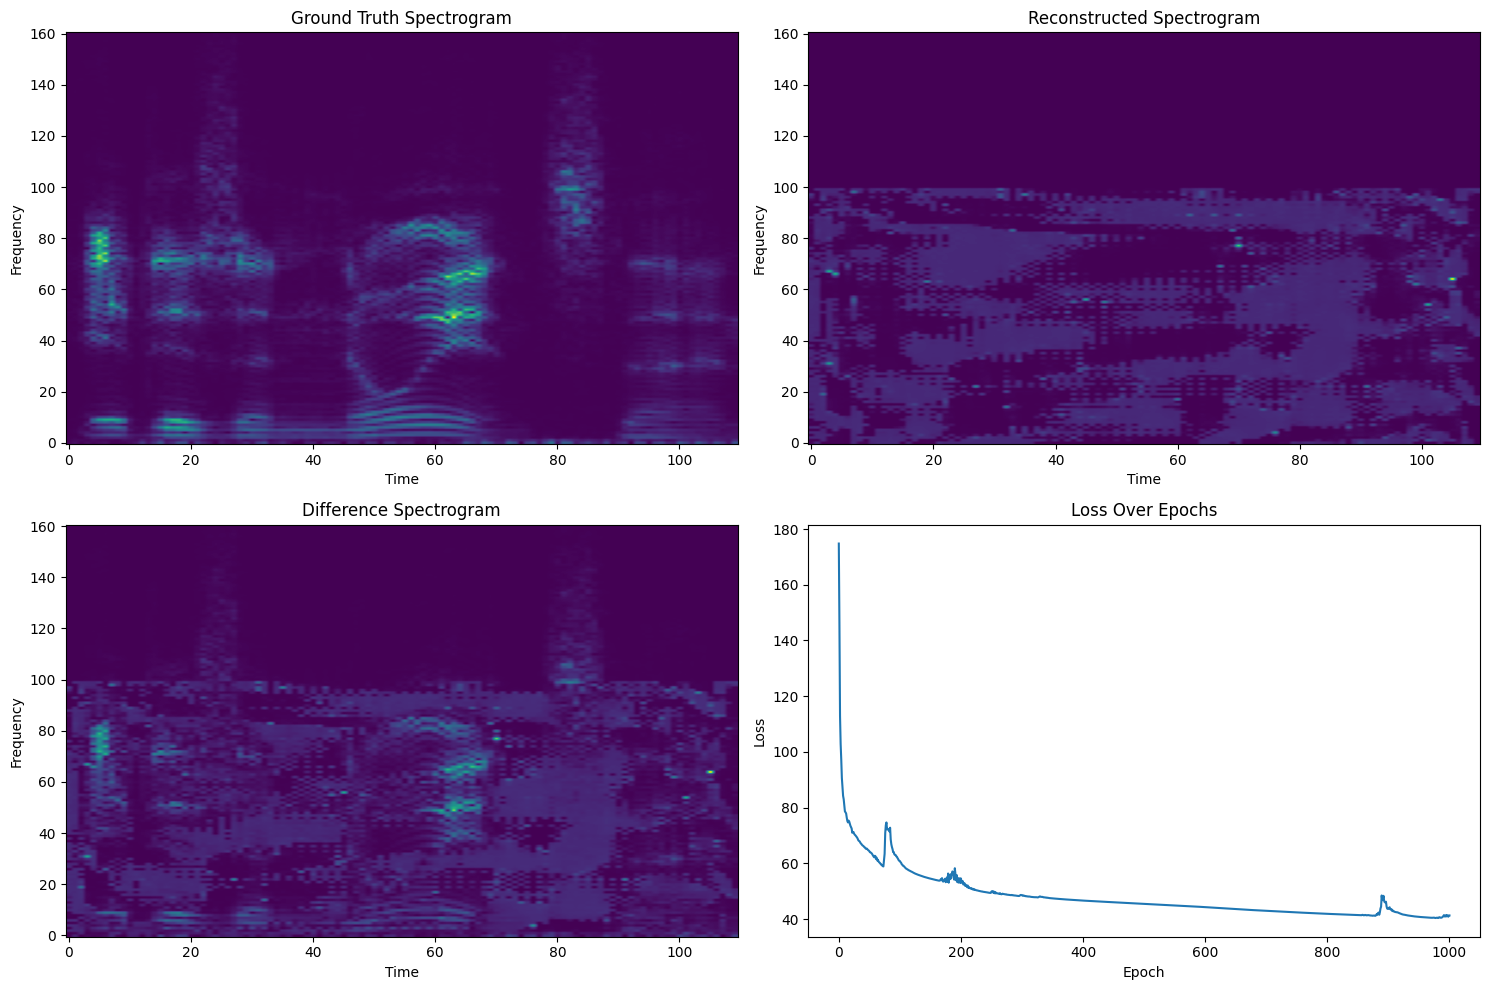

Iteration, Loss, Gradient Norm, Learning Rate: 1010, 40.7383, 20.6141, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 1020, 43.2758, 34.8441, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 1030, 41.6546, 31.4388, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 1040, 40.5269, 14.2052, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 1050, 40.1020, 7.6619, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 1060, 39.8713, 9.5296, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 1070, 39.7184, 5.0973, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 1080, 39.6314, 12.4655, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 1090, 39.5468, 14.6542, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 1100, 39.5225, 14.9276, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 1110, 41.1874, 59.7495, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 1120, 40.1862, 26.0663, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 1130, 39.6469, 12.99

In [12]:
while True:
    x_param_full= torch.concat([x_param, x_pad], dim=2)
    out, output_sizes, hs = model_ds(x_param_full, input_sizes) # 1 176 29
    out = out.transpose(0, 1)  # TxNxH
    out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

    # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
    mloss, dldw_f = meta_loss(out, targets, None, None, dldw_target,  weight_param)

    # L2 regularize
    # mloss += 1e-03 * torch.mean(x_param)

    optimizer.zero_grad()
    mloss.backward()
    grad = x_param.grad.data

    optimizer.step()
    scheduler.step(mloss)

    ## PROJECT NON NEGATIVE
    # x_param = x_param.clamp(min=0)
    # with torch.no_grad():
    x_param.data = torch.clamp( x_param.data, min=0)


    loss_history.append(mloss.item())

    if i % 10 == 0:
        print('Iteration, Loss, Gradient Norm, Learning Rate: {:4d}, {:.4f}, {:.4f}, {:.4f}'.format(i, mloss.item(), grad.norm().item(), optimizer.param_groups[0]["lr"]))
        # scheduler.step(mloss.item())

    if i % 1000 == 0:
        x_params_to_plot = torch.concat( [x_param, x_pad], dim=2)
        plot_four_graphs(inputs.detach(), x_params_to_plot.detach(), loss_history)

    i+=1

In [ ]:
while True:
    x_param_full= torch.concat([x_param, x_pad], dim=2)
    out, output_sizes, hs = model_ds(x_param_full, input_sizes) # 1 176 29
    out = out.transpose(0, 1)  # TxNxH
    out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

    # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
    mloss, dldw_f = meta_loss(out, targets, None, None, dldw_target,  weight_param)


    optimizer.zero_grad()
    mloss.backward()
    grad = x_param.grad.data

    optimizer.step()
    scheduler.step(mloss.item())

    ## PROJECT NON NEGATIVE
    # x_param = x_param.clamp(min=0)
    # with torch.no_grad():
    x_param.data = torch.clamp( x_param.data, min=0)


    loss_history.append(mloss.item())

    if i % 10 == 0:
        print('Iteration, Loss, Gradient Norm, Learning Rate: {:4d}, {:.4f}, {:.4f}, {:.4f}'.format(i, mloss.item(), grad.norm().item(), optimizer.param_groups[0]["lr"]))
        scheduler.step(mloss.item())

    if i % 1000 == 0:
        x_params_to_plot = torch.concat( [x_param, x_pad], dim=2)
        plot_four_graphs(inputs.detach(), x_params_to_plot.detach(), loss_history)

    i+=1

In [ ]:
for g in optimizer.param_groups:
    g['lr']=0.1


In [ ]:
x_params_to_plot.transpose(2,3).squeeze().mean(dim=0)

In [ ]:
model_ds.

In [ ]:

inputs.transpose(2,3).squeeze().mean(dim=0)

## Plot sth

In [ ]:
def plot_tensor_distribution(x_param):
    import seaborn as sns
    """
    Plot the distribution of values within a tensor.
    
    Args:
        x_param (torch.Tensor): The tensor to analyze.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(x_param.cpu().numpy().flatten(), bins=50, kde=True)
    plt.title('Distribution of Tensor Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
plot_tensor_distribution(x_param.detach())

In [ ]:
plot_tensor_distribution(inputs.detach())

In [ ]:
inputs.min()

In [ ]:
import numpy as np
np.log(1+7.9e-05)

In [ ]:
x_params.var()

In [ ]:
import seaborn as sns
def plot_tensor_distribution(x_param):
    """
    Plot the distribution of values within a tensor.
    
    Args:
        x_param (torch.Tensor): The tensor to analyze.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(x_param.cpu().numpy().flatten(), bins=50, kde=True)
    plt.title('Distribution of Tensor Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
inputs_TF = inputs.transpose(-1,-2)

In [ ]:
inputs_TF.mean(dim=2)

In [ ]:
def plot_stem_tensor(tensor):
    """
    Plot a flattened version of a tensor in a stem plot to visualize how values change.
    
    Args:
        tensor (torch.Tensor): The tensor to be plotted.
    """
    plt.figure(figsize=(12, 4))
    flattened_tensor = tensor.flatten().cpu().numpy()
    plt.stem(range(len(flattened_tensor)), flattened_tensor, use_line_collection=True)
    plt.title('Stem Plot of Tensor Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

In [ ]:
plot_stem_tensor(inputs_TF.mean(dim=2))

In [ ]:
model_ds.fc[0]

In [ ]:
1000 * 20